In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.float_format',lambda x:'%.3f' % x)
from pandas.tseries.offsets import *
from datetime import datetime, timedelta

C:\Users\YH817GQ\Anaconda3_new\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def plot_series(time,series,format='-'):
    plt.figure(figsize=(0,6)).set_figwidth(15)
    if type(series) is tuple:
        for series_num in series:
            plt.plot(time,series_num,format)
    else:
        plt.plot(time,series,format)
    
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.grid(True)
    plt.show

In [4]:
def train_test_split(data):
    size = int(len(data)*0.8)
    x_train = data.drop(columns=['close']).iloc[:size]
    x_test = data.drop(columns=['close']).iloc[size:]
    y_train = data['close'].iloc[:size]
    y_test = data['close'].iloc[size:]
    return x_train,x_test,y_train,y_test



def series_to_supervised(data,n_in=1,n_out=1,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_temp = pd.DataFrame(data)
    cols,names = list(),list()
    for i in range(n_in,0,-1):
        cols.append(df_temp.shift(i))
        names+=[('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0,n_out):
        cols.append(df_temp.shift(-1))
        if i==0:
            names+=[('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names+=[('var%d(t+%d)' % (j+1,i)) for j in range(n_vars)]
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def reshape_data(train,test):
    reframed_train = series_to_supervised(train,1,1)
    reframed_test = series_to_supervised(test,1,1)
    
    train = reframed_train.values
    test = reframed_test.values
    
    train_X,y_train = train[:,:-1],train[:,-1]
    test_X,y_test = test[:,:-1], test[:,-1]
    
    x_train = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))
    return x_train,x_test,y_train,y_test




In [313]:
df = pd.read_excel('tata_steel.xlsx')
# df['stock_name'] = 'tata_steel'
df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df['date'].dt.dayofweek+1
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter

df = pd.get_dummies(df,columns=['weekday','month','quarter'])
# df.drop(columns=['Open', 'High', 'Low', 'Adj Close'],axis=1,inplace=True)
df = df[~df.isna()]
df.head()

,date,close,volume,turnover,qty,hl,co,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
0,2023-01-02,119.250,481935,16899938209.600,47023511,5.950,4.850,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2023-01-03,118.450,279140,8859042586.450,20027658,2.750,-1.350,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2023-01-04,115.750,219447,6484836352.550,17954484,3.700,-3.000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2023-01-05,116.550,238074,6806057647.800,18665056,2.500,0.050,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2023-01-06,115.650,187180,6825354273.050,20167939,2.600,-1.350,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


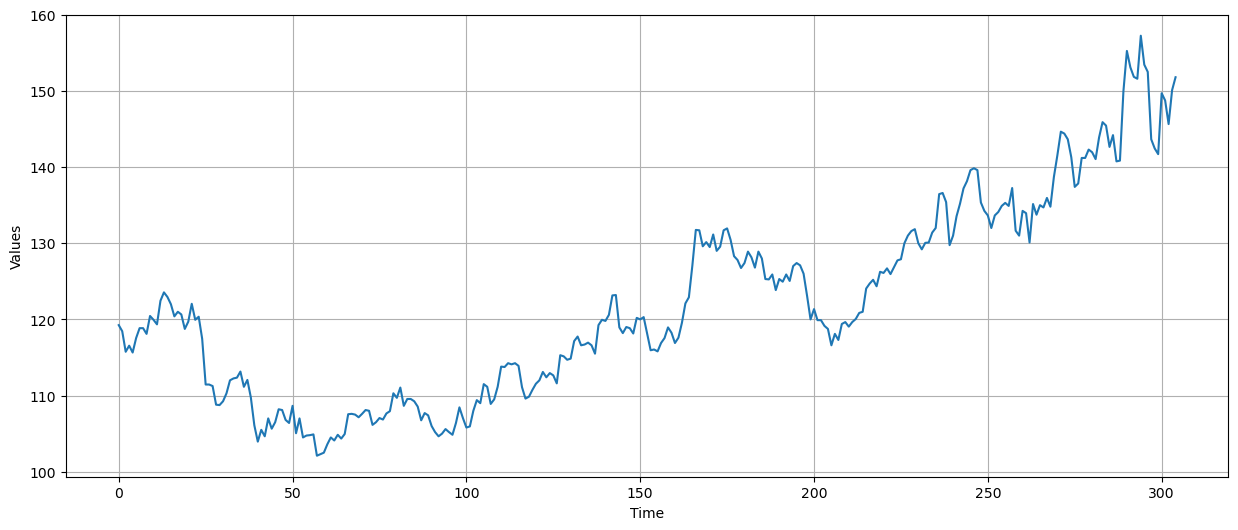

In [314]:
time = np.arange(len(df['close']))
series = df['close']
plot_series(time,series)

In [315]:
df.head()

,date,close,volume,turnover,qty,hl,co,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
0,2023-01-02,119.250,481935,16899938209.600,47023511,5.950,4.850,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2023-01-03,118.450,279140,8859042586.450,20027658,2.750,-1.350,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2023-01-04,115.750,219447,6484836352.550,17954484,3.700,-3.000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2023-01-05,116.550,238074,6806057647.800,18665056,2.500,0.050,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2023-01-06,115.650,187180,6825354273.050,20167939,2.600,-1.350,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [316]:
df = df.set_index('date')
df.head(10)

,close,volume,turnover,qty,hl,co,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-02,119.250,481935,16899938209.600,47023511,5.950,4.850,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2023-01-03,118.450,279140,8859042586.450,20027658,2.750,-1.350,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2023-01-04,115.750,219447,6484836352.550,17954484,3.700,-3.000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2023-01-05,116.550,238074,6806057647.800,18665056,2.500,0.050,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2023-01-06,115.650,187180,6825354273.050,20167939,2.600,-1.350,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2023-01-09,117.550,184045,4438628753.100,13017072,1.550,0.650,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2023-01-10,118.850,206267,6732375346.950,23267439,2.200,1.200,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2023-01-11,118.850,182298,5871210496.250,18092757,2.350,-0.600,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2023-01-12,118.100,127108,3986728182.750,11915232,1.650,-0.850,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [317]:
df.columns

Index(['close', 'volume', 'turnover', 'qty', 'hl', 'co', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'weekday_7', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4'],
      dtype='object')

In [318]:
df1 = series_to_supervised(df[['close']],7,7).merge(df,how='left',on='date')
df1.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),close,volume,turnover,qty,hl,co,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-11,119.250,118.450,115.750,116.550,115.650,117.550,118.850,118.100,118.100,118.100,118.100,118.100,118.100,118.100,118.850,182298,5871210496.250,18092757,2.350,-0.600,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2023-01-12,118.450,115.750,116.550,115.650,117.550,118.850,118.850,120.450,120.450,120.450,120.450,120.450,120.450,120.450,118.100,127108,3986728182.750,11915232,1.650,-0.850,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2023-01-13,115.750,116.550,115.650,117.550,118.850,118.850,118.100,119.950,119.950,119.950,119.950,119.950,119.950,119.950,120.450,242859,8287320121.450,22841088,3.450,1.900,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2023-01-16,116.550,115.650,117.550,118.850,118.850,118.100,120.450,119.350,119.350,119.350,119.350,119.350,119.350,119.350,119.950,178138,5314417958.050,20917533,2.650,-1.500,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2023-01-17,115.650,117.550,118.850,118.850,118.100,120.450,119.950,122.450,122.450,122.450,122.450,122.450,122.450,122.450,119.350,117336,3317731473.650,10116199,1.900,-0.400,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [319]:
df1.columns

Index(['var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)',
       'var1(t-2)', 'var1(t-1)', 'var1(t)', 'var1(t+1)', 'var1(t+2)',
       'var1(t+3)', 'var1(t+4)', 'var1(t+5)', 'var1(t+6)', 'close', 'volume',
       'turnover', 'qty', 'hl', 'co', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'quarter_1',
       'quarter_2', 'quarter_3', 'quarter_4'],
      dtype='object')

In [320]:
len(df1.columns)

43

In [321]:
df1 = df1[['var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)',
       'var1(t-2)', 'var1(t-1)',
           'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weekday_7', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'quarter_1', 'quarter_2',
       'quarter_3', 'quarter_4','var1(t)' ,'var1(t+1)', 'var1(t+2)',
       'var1(t+3)', 'var1(t+4)', 'var1(t+5)', 'var1(t+6)']]
df1.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-11,119.250,118.450,115.750,116.550,115.650,117.550,118.850,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,118.100,118.100,118.100,118.100,118.100,118.100,118.100
2023-01-12,118.450,115.750,116.550,115.650,117.550,118.850,118.850,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,120.450,120.450,120.450,120.450,120.450,120.450,120.450
2023-01-13,115.750,116.550,115.650,117.550,118.850,118.850,118.100,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,119.950,119.950,119.950,119.950,119.950,119.950,119.950
2023-01-16,116.550,115.650,117.550,118.850,118.850,118.100,120.450,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,119.350,119.350,119.350,119.350,119.350,119.350,119.350
2023-01-17,115.650,117.550,118.850,118.850,118.100,120.450,119.950,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,122.450,122.450,122.450,122.450,122.450,122.450,122.450


In [322]:
df_X,df_Y = df1.values[:,:-7],df1.values[:,-7:]

In [323]:
df_X


array([[119.25, 118.45, 115.75, ...,   0.  ,   0.  ,   0.  ],
       [118.45, 115.75, 116.55, ...,   0.  ,   0.  ,   0.  ],
       [115.75, 116.55, 115.65, ...,   0.  ,   0.  ,   0.  ],
       ...,
       [157.25, 153.45, 152.5 , ...,   0.  ,   0.  ,   0.  ],
       [153.45, 152.5 , 143.65, ...,   0.  ,   0.  ,   0.  ],
       [152.5 , 143.65, 142.45, ...,   0.  ,   0.  ,   0.  ]])

In [324]:
df_Y

array([[118.1 , 118.1 , 118.1 , ..., 118.1 , 118.1 , 118.1 ],
       [120.45, 120.45, 120.45, ..., 120.45, 120.45, 120.45],
       [119.95, 119.95, 119.95, ..., 119.95, 119.95, 119.95],
       ...,
       [145.65, 145.65, 145.65, ..., 145.65, 145.65, 145.65],
       [150.1 , 150.1 , 150.1 , ..., 150.1 , 150.1 , 150.1 ],
       [151.8 , 151.8 , 151.8 , ..., 151.8 , 151.8 , 151.8 ]])

In [325]:
X = df_X.reshape(df_X.shape[0],1,df_X.shape[1])
Y = df_Y

In [326]:
X.shape,Y.shape

((297, 1, 30), (297, 7))

In [327]:
X

array([[[119.25, 118.45, 115.75, ...,   0.  ,   0.  ,   0.  ]],

       [[118.45, 115.75, 116.55, ...,   0.  ,   0.  ,   0.  ]],

       [[115.75, 116.55, 115.65, ...,   0.  ,   0.  ,   0.  ]],

       ...,

       [[157.25, 153.45, 152.5 , ...,   0.  ,   0.  ,   0.  ]],

       [[153.45, 152.5 , 143.65, ...,   0.  ,   0.  ,   0.  ]],

       [[152.5 , 143.65, 142.45, ...,   0.  ,   0.  ,   0.  ]]])

In [328]:
Y

array([[118.1 , 118.1 , 118.1 , ..., 118.1 , 118.1 , 118.1 ],
       [120.45, 120.45, 120.45, ..., 120.45, 120.45, 120.45],
       [119.95, 119.95, 119.95, ..., 119.95, 119.95, 119.95],
       ...,
       [145.65, 145.65, 145.65, ..., 145.65, 145.65, 145.65],
       [150.1 , 150.1 , 150.1 , ..., 150.1 , 150.1 , 150.1 ],
       [151.8 , 151.8 , 151.8 , ..., 151.8 , 151.8 , 151.8 ]])

In [329]:
size = int(len(X)*0.8)
x_train = X[:size]
y_train = Y[:size]

x_test = X[size:]
y_test = Y[size:]

In [330]:
x_train.shape,y_train.shape

((237, 1, 30), (237, 7))

In [331]:
x_test.shape,y_test.shape

((60, 1, 30), (60, 7))

In [332]:
# Running LSTM

model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(7))
model.compile(loss='mae',optimizer='adam')
history = model.fit(x_train,y_train,epochs=30,batch_size=50,verbose=1,shuffle=False)

Epoch 1/30
5/5 [==============================] - 3s 7ms/step - loss: 112.9306
Epoch 2/30
5/5 [==============================] - 0s 6ms/step - loss: 97.5442
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 65.1192
Epoch 4/30
5/5 [==============================] - 0s 6ms/step - loss: 37.6321
Epoch 5/30
5/5 [==============================] - 0s 6ms/step - loss: 22.2367
Epoch 6/30
5/5 [==============================] - 0s 6ms/step - loss: 11.5060
Epoch 7/30
5/5 [==============================] - 0s 6ms/step - loss: 9.6274
Epoch 8/30
5/5 [==============================] - 0s 6ms/step - loss: 6.7424
Epoch 9/30
5/5 [==============================] - 0s 6ms/step - loss: 4.7987
Epoch 10/30
5/5 [==============================] - 0s 6ms/step - loss: 4.1136
Epoch 11/30
5/5 [==============================] - 0s 7ms/step - loss: 3.3688
Epoch 12/30
5/5 [==============================] - 0s 6ms/step - loss: 3.2658
Epoch 13/30
5/5 [==============================] - 0s 6ms/step - l

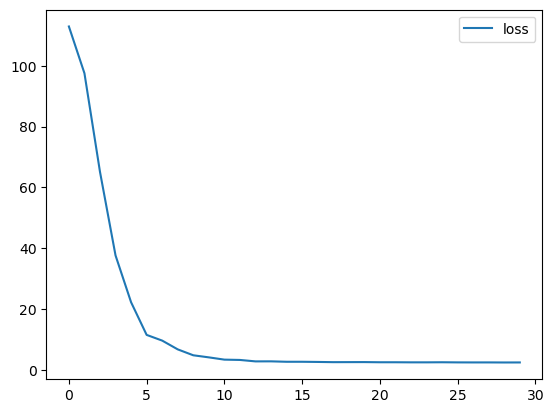

In [333]:
# Plot loss history
plt.plot(history.history['loss'],label='loss')
plt.legend()
plt.show()

In [334]:
y_test_pre = model.predict(x_test)
y_test_pre.shape,y_test.shape

2/2 [==============================] - 0s 7ms/step


((60, 7), (60, 7))

In [335]:
y_test_pre.shape

(60, 7)

In [336]:
y_test.shape

(60, 7)

In [337]:
# Make predictions
pred = pd.DataFrame()
pred['date'] = df1.reset_index()['date'][size:]
pred['predicted_close'] = list(pd.DataFrame(y_test_pre).iloc[:,0])
pred['actual_close'] = list(pd.DataFrame(y_test).iloc[:,0])
pred.head()

,date,predicted_close,actual_close
237,2023-12-28,135.922,139.600
238,2023-12-29,136.575,139.850
239,2024-01-01,136.020,139.600
240,2024-01-02,137.372,135.350
241,2024-01-03,138.469,134.250


2.4294978336697763

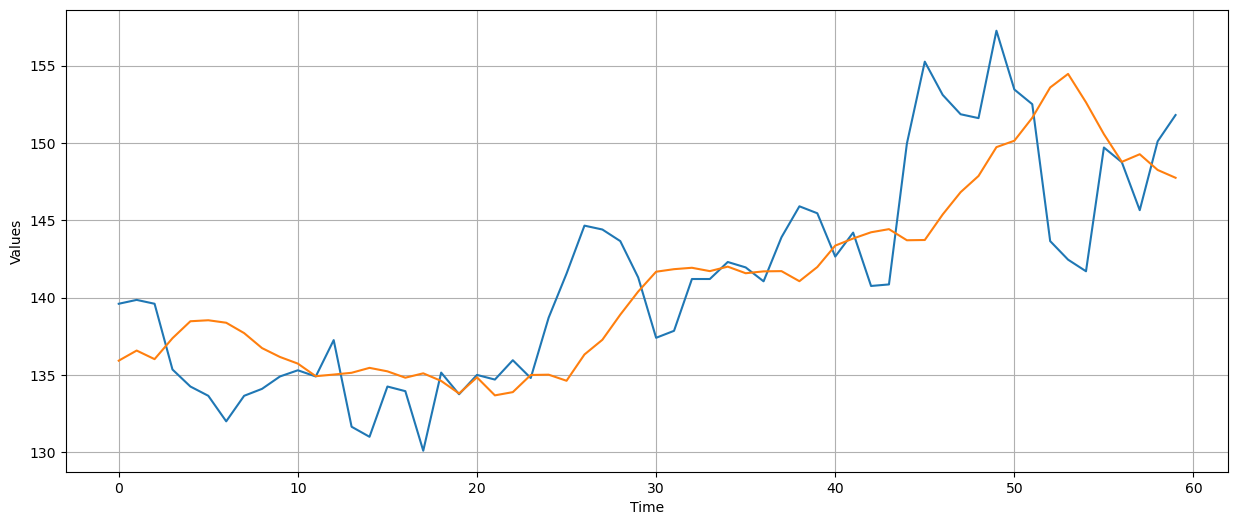

In [338]:
def measure_mape(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100

time = np.arange(len(pred))
series1 = pred['actual_close']
series2 = pred['predicted_close']
plot_series(time,(series1,series2))
display(measure_mape(series1,series2))

In [339]:
## oot forecastingo

In [340]:
# Running LSTM

model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(7))
model.compile(loss='mae',optimizer='adam')
history = model.fit(X,Y,epochs=30,batch_size=50,verbose=1,shuffle=False)

Epoch 1/30
6/6 [==============================] - 3s 6ms/step - loss: 117.1031
Epoch 2/30
6/6 [==============================] - 0s 7ms/step - loss: 96.6362
Epoch 3/30
6/6 [==============================] - 0s 6ms/step - loss: 43.8086
Epoch 4/30
6/6 [==============================] - 0s 6ms/step - loss: 26.3308
Epoch 5/30
6/6 [==============================] - 0s 6ms/step - loss: 13.2526
Epoch 6/30
6/6 [==============================] - 0s 6ms/step - loss: 8.7599
Epoch 7/30
6/6 [==============================] - 0s 6ms/step - loss: 6.3182
Epoch 8/30
6/6 [==============================] - 0s 6ms/step - loss: 3.6799
Epoch 9/30
6/6 [==============================] - 0s 6ms/step - loss: 3.1621
Epoch 10/30
6/6 [==============================] - 0s 6ms/step - loss: 3.4682
Epoch 11/30
6/6 [==============================] - 0s 6ms/step - loss: 3.5470
Epoch 12/30
6/6 [==============================] - 0s 6ms/step - loss: 2.5878
Epoch 13/30
6/6 [==============================] - 0s 6ms/step - lo

In [341]:
df1 = series_to_supervised(df[['close']].tail(8),7,0).merge(df,how='left',on='date')
df1

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),close,volume,turnover,qty,hl,co,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-22,143.650,142.450,141.700,149.700,148.750,145.650,150.100,151.800,311476,10325386812.250,18343685,4.400,2.800,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [342]:
len(df1.columns)

36

In [343]:
df1 = df1[['var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)',
       'var1(t-2)', 'var1(t-1)',
           'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weekday_7', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'quarter_1', 'quarter_2',
       'quarter_3', 'quarter_4']]
df1.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-22,143.650,142.450,141.700,149.700,148.750,145.650,150.100,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [351]:
df_X = df1.values[:,:]

In [352]:
df_X

array([[143.65, 142.45, 141.7 , 149.7 , 148.75, 145.65, 150.1 ,   0.  ,
          0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ]])

In [353]:
X = df_X.reshape(df_X.shape[0],1,df_X.shape[1])

In [354]:
X.shape

(1, 1, 30)

In [355]:
X

array([[[143.65, 142.45, 141.7 , 149.7 , 148.75, 145.65, 150.1 ,   0.  ,
           0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,
           1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
           0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ]]])

In [358]:
d = pd.DataFrame()
d['eod_date'] = pd.date_range(start='2024-03-25',end=pd.to_datetime('2024-03-25')+pd.DateOffset(6))
d['forecast'] = model.predict(X)[0]

1/1 [==============================] - 0s 42ms/step


In [359]:
d

,eod_date,forecast
0,2024-03-25,149.697
1,2024-03-26,149.894
2,2024-03-27,149.706
3,2024-03-28,146.923
4,2024-03-29,150.292
5,2024-03-30,148.591
6,2024-03-31,147.561
